In [24]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, Rzz, RX,KrausChannel,AmplitudeDampingChannel,PhaseDampingChannel,DepolarizingChannel,BitFlipChannel,PhaseFlipChannel
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 将数据保存在服务器上所需代码
import logging
import sys
import datetime

In [25]:
#在服务器上存储日志数据
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''

    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

    logging.basicConfig(
        level=logging.INFO,
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename),
            logging.StreamHandler(sys.stdout)
        ]
    )

    # Test
    logger = logging.getLogger(logger_name)
    #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("data/test optimizers.log", "ml_logger")

[(0, 1), (0, 4), (0, 3), (0, 2), (1, 2), (1, 4), (1, 3), (2, 4), (2, 3), (4, 3)]


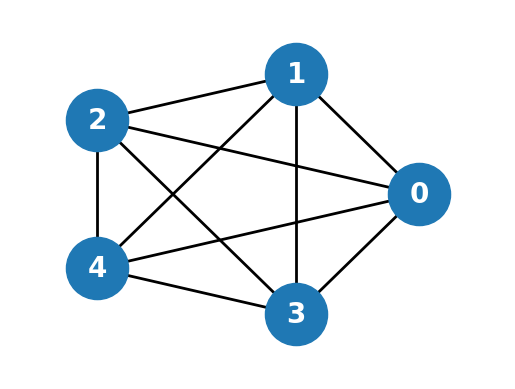

graph=Graph with 5 nodes and 10 edges


In [26]:
#绘制k-正则图
n=5
k=n-1
V = [] # 顶点集合
for i in range(0,n):
    V.append(i)
# 正则度k(k需为偶数)，顶点数n
graph = nx.random_graphs.random_regular_graph(k,n)  #生成包含n个节点、每个节点有k个邻居的规则图RG
print(graph.edges)
# 将生成的图 G 打印出来
pos = nx.circular_layout(graph)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(graph, pos, **options)
# graph
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()
my_logger.info('graph={}'.format(graph))

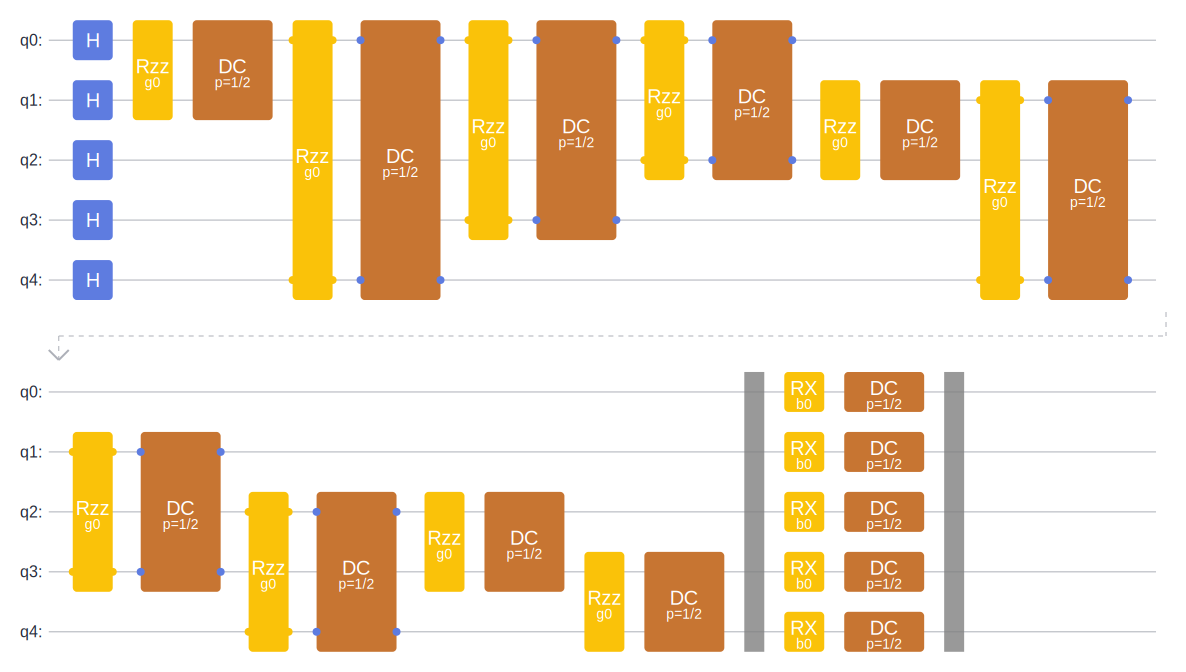

In [27]:
p1=0.5
#去极化信道
def build_hc(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=DepolarizingChannel(p1,2).on(i)
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit() 
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=DepolarizingChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc(g,f'g{i}')
        circ+=build_hb(g,f'b{i}')        
    return circ
#构建图对应的哈密顿量Hc
def build_ham(g):
    ham=QubitOperator()
    for i in g.edges:
        ham+=QubitOperator(f'Z{i[0]} Z{i[1]}')
    return ham
#选择p = 4，表示选用4层的QAOA量子线路，ansatz是求解该问题的量子线路，init_state_circ是将量子态制备到均匀叠加态（HB的基态）上的量子线路
p=1
ham=Hamiltonian(build_ham(graph))
init_state_circ=UN(H,graph.nodes)
ansatz=build_ansatz(graph,p)
circ=init_state_circ+ansatz
circ.svg(width=1200)

In [31]:
## Adam同时使用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。 一阶矩来控制模型更新的方向，二阶矩控制步长(学习率)。
# optimize the parameters
sim = Simulator('mqvector', circ.n_qubits)   
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子 
print(grad_ops)
# net = MQAnsatzOnlyLayer(grad_ops) 
# max_cuts=[]
# opti=nn.Adam(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
# train_net=nn.TrainOneStepCell(net,opti)# 对神经网络采用设定优化器opti进行一步训练
# #训练，展示max_cut问题求解
# for i in range(300):
#     cut=(len(graph.edges)-train_net())/2
#     if i%10==0:
#         #print("train step:",i,",cut:",cut)
#         cut=cut.numpy()
#         max_cuts.append(cut)
# #该问题哈密顿量的基态能量对应的边切割数趋近于6。
# ratio1=[]
# mean_ratio1=[]
# pr=dict(zip(ansatz.params_name,net.weight.asnumpy()))
# print(pr)
# mean_max_cuts = np.mean(max_cuts)
# max_max_cuts=np.max(max_cuts)
# print("最大割：",max_max_cuts)
# print(max_cuts)
# for i in range(len(max_cuts)):
#     ratio1.append(max_cuts[i]/max_max_cuts)
# mean_ratio1=np.mean(max_cuts/max_max_cuts)
# print("平均近似比率：",mean_ratio1)

NameError: name 'var_x' is not defined

In [30]:
#1)利用传统优化算法完成优化搜索
sim=Simulator('mqvector',circ.n_qubits)
grad_opts=sim.get_expectation_with_grad(ham,circ)
#利用模拟器生成计算QAOA变分量子线路期望值和梯度的运算算子。

#通过如下方式计算线路在参数为10个随机生成 p0 时的期望值和导数。
rng=np.random.default_rng(10)
p0=rng.random(size=len(circ.params_name))*np.pi*2-np.pi
print(p0)
f,g=grad_opts(p0)
print('Expectation Value: ', f)
#期望值是一个(1,1)维的数组，其中m表示本次运算将多少数据通过编码器编码成了量子态，由于QAOA任务不用编码器，因此m
#取默认值1，n表示本次运算计算了多少个哈密顿量期望值（MindQuantum支持多哈密顿量并行处理），此处我们只计算了ham的期望值
print('Expectation Value Shape: ', f.shape)
print('Gradient: ', g)
#对于梯度值来说，它的维度是(1, 1, 8)，新增的维度k=8表示整个线路中的ansatz变分参数个数。g0-g3和b0-b3
print('Gradient Shape: ', g.shape)

[ 2.86514324 -1.83668936]
Expectation Value:  [[-0.60365384-1.01915004e-17j]]
Expectation Value Shape:  (1, 1)
Gradient:  [[[ 0.59874867+0.j -0.59779029+0.j]]]
Gradient Shape:  (1, 1, 2)


In [9]:
#2)引入scipy中的二阶优化器BFGS来对Max-Cut问题进行优化，为此首先定义待优化函数
global step
step=0
def fun(p,grad_opts):
    global step
    f,g=grad_opts(p)
    f=np.real(f)[0,0]
    g=np.real(g)[0,0]
    step+=1
    if step%10==0:
        print(f"train step:{step},cut:[{(len(graph.edges)-f)/2}]")
    return f,g
fun(p0,grad_opts)
#采用BFGS的二阶优化方法，指定jac=True，表示告诉优化器，待优化的函数在返回函数值的同时也会返回梯度值。如设定为False，优化器会利用差分法自行计算近似梯度，这会消耗大量算力。

(-0.18712103857060314,
 array([ 4.44548635, -5.14236424,  2.39468671,  3.04815068, -3.83994603,
         2.26138323,  0.42723338,  3.51401993]))

In [10]:
from scipy.optimize import minimize

step = 0
res = minimize(fun, p0, args=(grad_opts, ), method='bfgs', jac=True)

print(dict(zip(circ.params_name, res.x)))
#在最优解时，训练得到的变分参数为

train step:10,cut:[5.963459046627013]
train step:20,cut:[5.992372408251943]
train step:30,cut:[5.9937723162519365]
{'g0': 2.369790229712812, 'b0': -1.0355250473159925, 'g1': 1.2299264368855285, 'b1': -2.454623069130831, 'g2': 0.6130878157473683, 'b2': -2.6515158915795527, 'g3': 1.1195843405712782, 'b3': 1.3210460327202374}


In [11]:
#3)利用 MindSpore 机器学习框架完成量子神经网络训练
#搭建待训练量子神经网络
#使用MQAnsatzOnlyLayer作为待训练的量子神经网络，并采用Adam优化器。

import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE,device_target='CPU')
sim=Simulator('mqvector',circ.n_qubits) # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops=sim.get_expectation_with_grad(ham,circ) # 获取sim计算变分量子线路的期望值和梯度的算子

net=MQAnsatzOnlyLayer(grad_ops)# # 生成待训练的神经网络

In [12]:
## Adam同时使用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。 一阶矩来控制模型更新的方向，二阶矩控制步长(学习率)。
max_cuts=[]
opti1=nn.Adam(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net1=nn.TrainOneStepCell(net,opti1)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net1())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr1=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio1=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio1)
mean_ratio1 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio1)

train step: 0 ,cut: [5.000201]
train step: 10 ,cut: [5.9156413]
train step: 20 ,cut: [5.979254]
train step: 30 ,cut: [5.915244]
train step: 40 ,cut: [5.9780617]
train step: 50 ,cut: [5.982663]
train step: 60 ,cut: [5.996968]
train step: 70 ,cut: [5.985029]
train step: 80 ,cut: [5.94527]
train step: 90 ,cut: [5.9874535]
train step: 100 ,cut: [5.990923]
train step: 110 ,cut: [5.9857774]
train step: 120 ,cut: [5.9581947]
train step: 130 ,cut: [5.9590693]
train step: 140 ,cut: [5.974072]
train step: 150 ,cut: [5.988405]
train step: 160 ,cut: [5.993759]
train step: 170 ,cut: [5.999576]
train step: 180 ,cut: [5.990015]
train step: 190 ,cut: [5.535776]
train step: 200 ,cut: [5.295066]
train step: 210 ,cut: [5.985791]
train step: 220 ,cut: [5.9970255]
train step: 230 ,cut: [5.9914427]
train step: 240 ,cut: [5.9878273]
train step: 250 ,cut: [5.9874983]
train step: 260 ,cut: [5.448084]
train step: 270 ,cut: [5.9832816]
train step: 280 ,cut: [5.9958653]
train step: 290 ,cut: [5.9861155]
最大割： 5.99

In [13]:
opti2=nn.SGD(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net2=nn.TrainOneStepCell(net,opti2)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net2())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr2=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio2=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio2)
mean_ratio2 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio2)

train step: 0 ,cut: [5.9933214]
train step: 10 ,cut: [5.537648]
train step: 20 ,cut: [5.9583716]
train step: 30 ,cut: [5.931273]
train step: 40 ,cut: [5.9808373]
train step: 50 ,cut: [5.9054723]
train step: 60 ,cut: [5.8378115]
train step: 70 ,cut: [5.933096]
train step: 80 ,cut: [5.8826804]
train step: 90 ,cut: [5.8447886]
train step: 100 ,cut: [5.5411887]
train step: 110 ,cut: [5.879727]
train step: 120 ,cut: [5.967042]
train step: 130 ,cut: [5.9620543]
train step: 140 ,cut: [5.95053]
train step: 150 ,cut: [5.910609]
train step: 160 ,cut: [5.0214534]
train step: 170 ,cut: [5.949792]
train step: 180 ,cut: [5.91601]
train step: 190 ,cut: [5.3100715]
train step: 200 ,cut: [5.977421]
train step: 210 ,cut: [5.875838]
train step: 220 ,cut: [5.9716163]
train step: 230 ,cut: [5.961689]
train step: 240 ,cut: [5.442885]
train step: 250 ,cut: [5.8467975]
train step: 260 ,cut: [5.981697]
train step: 270 ,cut: [5.928556]
train step: 280 ,cut: [5.984852]
train step: 290 ,cut: [5.9860125]
最大割： 5.99

In [14]:
#Momentum通过将当前梯度与过去梯度加权平均，来获取即将更新的梯度，有助于在相关方向上加速SGD并抑制振荡。
opti3=nn.Momentum(net.trainable_params(),learning_rate=0.05,momentum=0.9, weight_decay=0.0) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net3=nn.TrainOneStepCell(net,opti3)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net3())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr3=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio3=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio3)
mean_ratio3 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio3)

train step: 0 ,cut: [5.982106]
train step: 10 ,cut: [5.7338114]
train step: 20 ,cut: [5.5988817]
train step: 30 ,cut: [5.681591]
train step: 40 ,cut: [5.2766523]
train step: 50 ,cut: [3.5396495]
train step: 60 ,cut: [5.358746]
train step: 70 ,cut: [5.3010497]
train step: 80 ,cut: [3.4265566]
train step: 90 ,cut: [4.7312336]
train step: 100 ,cut: [5.7081842]
train step: 110 ,cut: [2.85089]
train step: 120 ,cut: [2.0554705]
train step: 130 ,cut: [5.05068]
train step: 140 ,cut: [2.1974475]
train step: 150 ,cut: [4.3448753]
train step: 160 ,cut: [2.188289]
train step: 170 ,cut: [4.8298135]
train step: 180 ,cut: [1.1265726]
train step: 190 ,cut: [4.0729747]
train step: 200 ,cut: [3.8123665]
train step: 210 ,cut: [3.4681082]
train step: 220 ,cut: [3.7312675]
train step: 230 ,cut: [4.111187]
train step: 240 ,cut: [4.3838034]
train step: 250 ,cut: [5.42098]
train step: 260 ,cut: [3.217247]
train step: 270 ,cut: [5.2095985]
train step: 280 ,cut: [4.403815]
train step: 290 ,cut: [2.4195244]
最大割：

In [15]:
opti4=nn.Adagrad(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net4=nn.TrainOneStepCell(net,opti4)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net4())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr4=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio4=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio4)
mean_ratio4 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio4)

train step: 0 ,cut: [3.9560943]
train step: 10 ,cut: [5.990613]
train step: 20 ,cut: [5.999513]
train step: 30 ,cut: [5.997365]
train step: 40 ,cut: [5.997293]
train step: 50 ,cut: [4.1294937]
train step: 60 ,cut: [5.199911]
train step: 70 ,cut: [4.6068635]
train step: 80 ,cut: [5.9983473]
train step: 90 ,cut: [5.9980474]
train step: 100 ,cut: [5.9948554]
train step: 110 ,cut: [5.999528]
train step: 120 ,cut: [5.9975996]
train step: 130 ,cut: [5.9985337]
train step: 140 ,cut: [5.5457354]
train step: 150 ,cut: [5.9977527]
train step: 160 ,cut: [5.998665]
train step: 170 ,cut: [5.9942303]
train step: 180 ,cut: [5.9994]
train step: 190 ,cut: [3.7201643]
train step: 200 ,cut: [3.8049111]
train step: 210 ,cut: [5.999193]
train step: 220 ,cut: [5.2517667]
train step: 230 ,cut: [5.9974904]
train step: 240 ,cut: [5.9969606]
train step: 250 ,cut: [5.365271]
train step: 260 ,cut: [5.999875]
train step: 270 ,cut: [5.268967]
train step: 280 ,cut: [5.999202]
train step: 290 ,cut: [5.997482]
最大割： 5.

In [16]:
# circ.measure_all()                               # 为线路中所有比特添加测量门
# sim.sampling(circ, pr=pr, shots=1000).svg()  

In [17]:

opti5=nn.Adadelta(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net5=nn.TrainOneStepCell(net,opti5)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net5())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr5=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio5=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio5)
mean_ratio5= mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio5)

train step: 0 ,cut: [5.995613]
train step: 10 ,cut: [5.9967804]
train step: 20 ,cut: [5.0641055]
train step: 30 ,cut: [5.997853]
train step: 40 ,cut: [5.9979615]
train step: 50 ,cut: [5.998071]
train step: 60 ,cut: [5.998477]
train step: 70 ,cut: [5.998564]
train step: 80 ,cut: [5.0398483]
train step: 90 ,cut: [5.9987845]
train step: 100 ,cut: [5.999017]
train step: 110 ,cut: [5.9991035]
train step: 120 ,cut: [5.999312]
train step: 130 ,cut: [5.018084]
train step: 140 ,cut: [5.9992194]
train step: 150 ,cut: [5.9993057]
train step: 160 ,cut: [5.999335]
train step: 170 ,cut: [5.999396]
train step: 180 ,cut: [5.999431]
train step: 190 ,cut: [5.9993496]
train step: 200 ,cut: [5.999358]
train step: 210 ,cut: [5.999401]
train step: 220 ,cut: [5.199898]
train step: 230 ,cut: [5.2621207]
train step: 240 ,cut: [5.9994698]
train step: 250 ,cut: [5.9994454]
train step: 260 ,cut: [5.9994526]
train step: 270 ,cut: [5.9994884]
train step: 280 ,cut: [4.4788094]
train step: 290 ,cut: [5.9996233]
最大割： 

In [ ]:
#https://blog.csdn.net/xian0710830114/article/details/128658682
sim = Simulator('mqvector', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
p0=rng.random(size=len(circ.params_name))*np.pi*2-np.pi
# net = MQAnsatzOnlyLayer(grad_ops)
iter=500
LR = 0.05
# 定义不同的优化器网络
net_SGD = MQAnsatzOnlyLayer(grad_ops)#带动量 的SGD 优化算法，Momentum通过将当前梯度与过去梯度加权平均，来获取即将更新的梯度，有助于在相关方向上加速SGD并抑制振荡。
net_Momentum =  MQAnsatzOnlyLayer(grad_ops)#同上
net_Adam=  MQAnsatzOnlyLayer(grad_ops)#同时使用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。 一阶矩来控制模型更新的方向，二阶矩控制步长(学习率)。
net_Adadelta=  MQAnsatzOnlyLayer(grad_ops)#  对于每个维度,用梯度平方的指数加权平均代替了全部梯度的平方和,避免了后期更新时更新幅度逐渐趋近于0的问题。用更新量的平方的指数加权平均来动态得代替了全局的标量的学习率,避免了对学习率的敏感。
net_Adagrad= MQAnsatzOnlyLayer(grad_ops)# 每个时间步长对每个参数使用不同的学习率。 引入了梯度的二阶矩，二阶矩是迄今为止所有梯度值的平方和，二阶矩的越大，代表步长的不确定性越大，学习率就越小，反之学习率越大。
#net_RMSprop = MQAnsatzOnlyLayer(grad_ops)#与Adadelta同一时期，等价于实现了Adadelta的第一个改动。
#net_Adamax = MQAnsatzOnlyLayer(grad_ops)# 在Adam的基础上，为学习率的上限限制了范围。将Adam的二范数（二阶矩估计）推广到无穷范数，因为无穷范数，就是取向量的最大值，这就为学习率的上限提供了一个更简单的范围。
#net_AdamW = MQAnsatzOnlyLayer(grad_ops)# 使用adam+权重衰减的方式解决了adam+L2正则化表现不佳的问题。

# 选择不同的优化方法

opt_SGD = nn.SGD(net_SGD.trainable_params(),learning_rate=LR)
opt_Momentum = nn.Momentum(net_Momentum.trainable_params(), learning_rate=LR, momentum=0.9)
opt_Adagrad = nn.Adagrad(net_Adagrad.trainable_params(), learning_rate=LR)
opt_Adadelta = nn.Adadelta(net_Adadelta.trainable_params(), learning_rate=LR)
#opt_RMSprop = nn.RMSprop(net_RMSprop.trainable_params(), learning_rate=LR, alpha=0.9)
opt_Adam = nn.Adam(net_Adam.trainable_params(), learning_rate=LR)
# opt_Adamax =nn.Adamax(net_Adamax.trainable_params(), learning_rate=LR, betas=(0.9, 0.99))
# opt_AdamW = nn.AdamW(net_AdamW.trainable_params(), learning_rate=LR, betas=(0.9, 0.99))
#opt_BFGS =nn.LBFGS(net_LBFGS.parameters(), lr=LR, max_iter=10, max_eval=10)

nets = [net_SGD, net_Momentum, net_Adam, net_Adadelta,net_Adagrad]
optimizers = [opt_SGD, opt_Momentum, opt_Adagrad, opt_Adam,opt_Adadelta]
#选定损失函数
loss_func =nn.MSELoss()#用于计算预测值与标签值之间的均方误差。
# 不同方法的loss
loss_SGD = []
loss_Momentum = []
loss_Adagrad = []
loss_Adadelta = []
#loss_RMSprop = []
loss_Adam = []
# loss_Adamax = []
# loss_AdamW = []
# 保存所有loss
#losses = [loss_SGD, loss_Momentum, loss_Adagrad, loss_Adadelta, loss_RMSprop, loss_Adam, loss_Adamax, loss_AdamW]
losses = [loss_SGD, loss_Momentum, loss_Adagrad, loss_Adadelta,  loss_Adam]
# 执行训练
for epoch in range(1000):
    for net, optimizer, loss_history in zip(nets, optimizers, losses):
            if isinstance(optimizer, nn.Adam):
                def closure():
                    y_pred = net(var_x)
                    loss = loss_func(y_pred, var_y)
                    optimizer.zero_grad()
                    loss.backward()
                    return loss
                loss = optimizer.step(closure)
            else:
                # 对x进行预测
                prediction = net(var_x)
                # 计算损失
                loss = loss_func(prediction, var_y)
                # 每次迭代清空上一次的梯度
                optimizer.zero_grad()
                # 反向传播
                loss.backward()
                # 更新梯度
                optimizer.step()
            # 保存loss记录
            loss_history.append(loss.data)


NameError: name 'var_x' is not defined